In [134]:
import importlib
import os
from datetime import datetime, timedelta, date

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from data_collection import DataCollection
from lstm_stock_prediction import LSTMStockPredictor as lstm

import data_plotter
importlib.reload(data_plotter)
from data_plotter import DataPlotter

import preprocessing
importlib.reload(preprocessing)
from preprocessing import Preprocessing

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### DATA PREPARATION #####

In [107]:
# Parameters
predicted_days = 1
tickers = ["GOOGL"]
start_date = "2000-01-01"
end_date = datetime.today().date() - timedelta(days=predicted_days)
sequence_length = 100 # todo 30, 50, 100, 365
batch_size = 32 # todo 16, 32, 64
data_path = "./data"
os.makedirs(data_path, exist_ok=True)

# Data collection
data_collector = DataCollection(tickers, start_date, end_date, folder_path=data_path)
data_collector.fetch_and_save_all()

# Preprocessing
pp = Preprocessing(folder_path=data_path, split_ratio=0.8, sequence_length=sequence_length)
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_train_dates, x_test_dates, y_train_dates, y_test_dates = pp.preprocess_pipeline()

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(x_train_tensor, y_train_tensor) # TensorDataset is a PyTorch utility that pairs input and target tensors together
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


Data saved to ./data\GOOGL_data.csv


##### MODEL SETUP #####

In [109]:
input_size = 5  # ['Open', 'High', 'Low', 'Close', 'Volume']
hidden_size = 128  # Number of hidden units in LSTM # todo 32, 50, 64, or 128
output_size = 5  # Predicting 5 values for the next day
num_layers = 2  # LSTM layers # todo 1 to 3
dropout = 0.2  # Dropout rate for regularization # todo 0.1 to 0.5
learning_rate = 0.0001 # todo 0.001, 0.0005, 0.0001

# Instantiate the model
model = lstm(input_sz=input_size, hidden_sz=hidden_size, output_sz=output_size).to(device) # todo Bidirectional LSTM, Gated Recurrent Unit (GRU)

# Loss and optimizer
criterion = nn.MSELoss() # todo Mean Absolute Error (MAE = L1Loss()), Mean Squared Error (MSE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # todo Adam, AdamW

##### TRAINING THE MODEL #####

In [110]:
num_epochs = 200 # todo 50, 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.6f}")

Epoch [1/200], Loss: 0.062958
Epoch [2/200], Loss: 0.003319
Epoch [3/200], Loss: 0.002080
Epoch [4/200], Loss: 0.001619
Epoch [5/200], Loss: 0.001412
Epoch [6/200], Loss: 0.001236
Epoch [7/200], Loss: 0.001090
Epoch [8/200], Loss: 0.001045
Epoch [9/200], Loss: 0.000902
Epoch [10/200], Loss: 0.000848
Epoch [11/200], Loss: 0.000828
Epoch [12/200], Loss: 0.000808
Epoch [13/200], Loss: 0.000794
Epoch [14/200], Loss: 0.000776
Epoch [15/200], Loss: 0.000758
Epoch [16/200], Loss: 0.000740
Epoch [17/200], Loss: 0.000726
Epoch [18/200], Loss: 0.000715
Epoch [19/200], Loss: 0.000708
Epoch [20/200], Loss: 0.000692
Epoch [21/200], Loss: 0.000685
Epoch [22/200], Loss: 0.000670
Epoch [23/200], Loss: 0.000664
Epoch [24/200], Loss: 0.000662
Epoch [25/200], Loss: 0.000645
Epoch [26/200], Loss: 0.000653
Epoch [27/200], Loss: 0.000675
Epoch [28/200], Loss: 0.000631
Epoch [29/200], Loss: 0.000622
Epoch [30/200], Loss: 0.000633
Epoch [31/200], Loss: 0.000635
Epoch [32/200], Loss: 0.000606
Epoch [33/200], L

##### EVALUATING THE MODEL #####

Test Loss: 0.0028
Date: 2021-03-24
Sample prediction (original scale): 101.37, 102.47, 99.88, 101.33, 20578200.00
Actual values (original scale): 102.59, 103.38, 101.45, 101.63, 25218000.00
--------------------------------------------------
Date: 2021-03-25
Sample prediction (original scale): 101.70, 102.77, 100.29, 101.68, 20487840.00
Actual values (original scale): 101.45, 102.28, 99.80, 101.62, 35616000.00
--------------------------------------------------
Date: 2021-03-26
Sample prediction (original scale): 100.97, 102.06, 99.51, 100.97, 25348360.00
Actual values (original scale): 101.59, 101.97, 100.19, 101.24, 27978000.00
--------------------------------------------------
Date: 2021-03-29
Sample prediction (original scale): 100.62, 101.70, 99.12, 100.60, 18764160.00
Actual values (original scale): 101.11, 102.46, 100.27, 102.29, 26492000.00
--------------------------------------------------
Date: 2021-03-30
Sample prediction (original scale): 100.86, 101.93, 99.36, 100.82, 182601

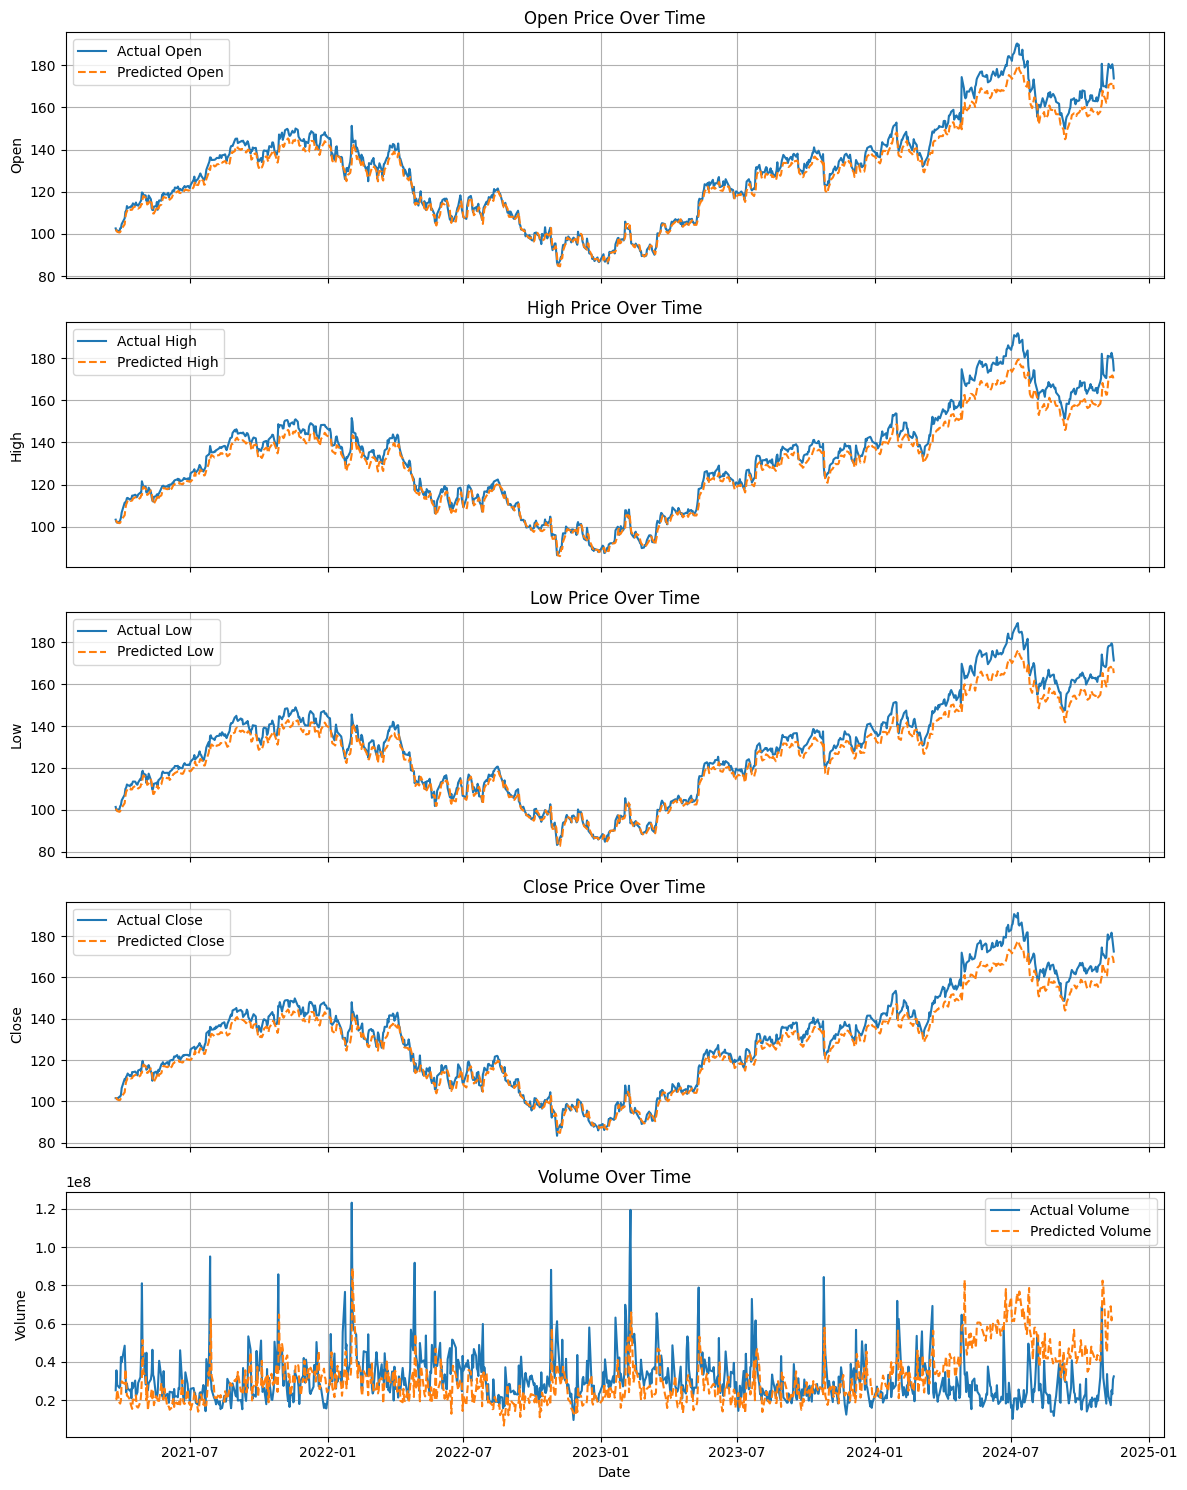

In [112]:
model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        output, _ = model(x_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.item()
        predictions.append(output.cpu())
        actuals.append(y_batch.cpu())

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# Post-processing predictions and actuals for inverse scaling
predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

# Split predictions and actuals into two parts: one for OHLC and one for Volume
predictions_ohlc = predictions[:, :4]  # First 4 columns are OHLC
predictions_volume = predictions[:, 4:]  # Last column is Volume

actuals_ohlc = actuals[:, :4]
actuals_volume = actuals[:, 4:]

# Inverse transform OHLC using pp.scaler
predictions_ohlc_original = pp.scaler.inverse_transform(predictions_ohlc)
actuals_ohlc_original = pp.scaler.inverse_transform(actuals_ohlc)

# Inverse transform Volume using pp.volume_scaler
predictions_volume_original = pp.volume_scaler.inverse_transform(predictions_volume)
actuals_volume_original = pp.volume_scaler.inverse_transform(actuals_volume)

# Combine OHLC and Volume back into the final format
predictions_original, predictions_scaled = np.hstack([predictions_ohlc_original, predictions_volume_original])
actuals_original = np.hstack([actuals_ohlc_original, actuals_volume_original])


for i in range(5):
    print(f"Date: {y_test_dates[i]}")
    prediction_str = ", ".join([f"{x:.2f}" for x in predictions_original[i]])
    actual_str = ", ".join([f"{x:.2f}" for x in actuals_original[i]])
    print(f"Sample prediction (original scale): {prediction_str}")
    print(f"Actual values (original scale): {actual_str}")
    print("-" * 50)

# Plotting results
plotter = DataPlotter()
df_results = plotter.create_results_dataframe(y_test_dates, actuals_original, predictions_original)
plotter.plot_results(df_results)

##### Predict ######


Predictions vs Actuals starting from 2023-01-03 for 2 days:
Date: 2023-01-04
Predicted: [8.7478760e+01 8.8464470e+01 8.6290970e+01 8.7538658e+01 2.0302516e+07]
Actual: [9.03499985e+01 9.06500015e+01 8.72699966e+01 8.80800018e+01
 3.48548000e+07]
---
Date: 2023-01-05
Predicted: [8.7416618e+01 8.8389008e+01 8.6260605e+01 8.7488281e+01 1.8363736e+07]
Actual: [8.74700012e+01 8.75699997e+01 8.59000015e+01 8.61999969e+01
 2.71944000e+07]
---
Test Metrics:
MSE: 0.000255
MAE: 0.012421
Variance of errors: 0.000213


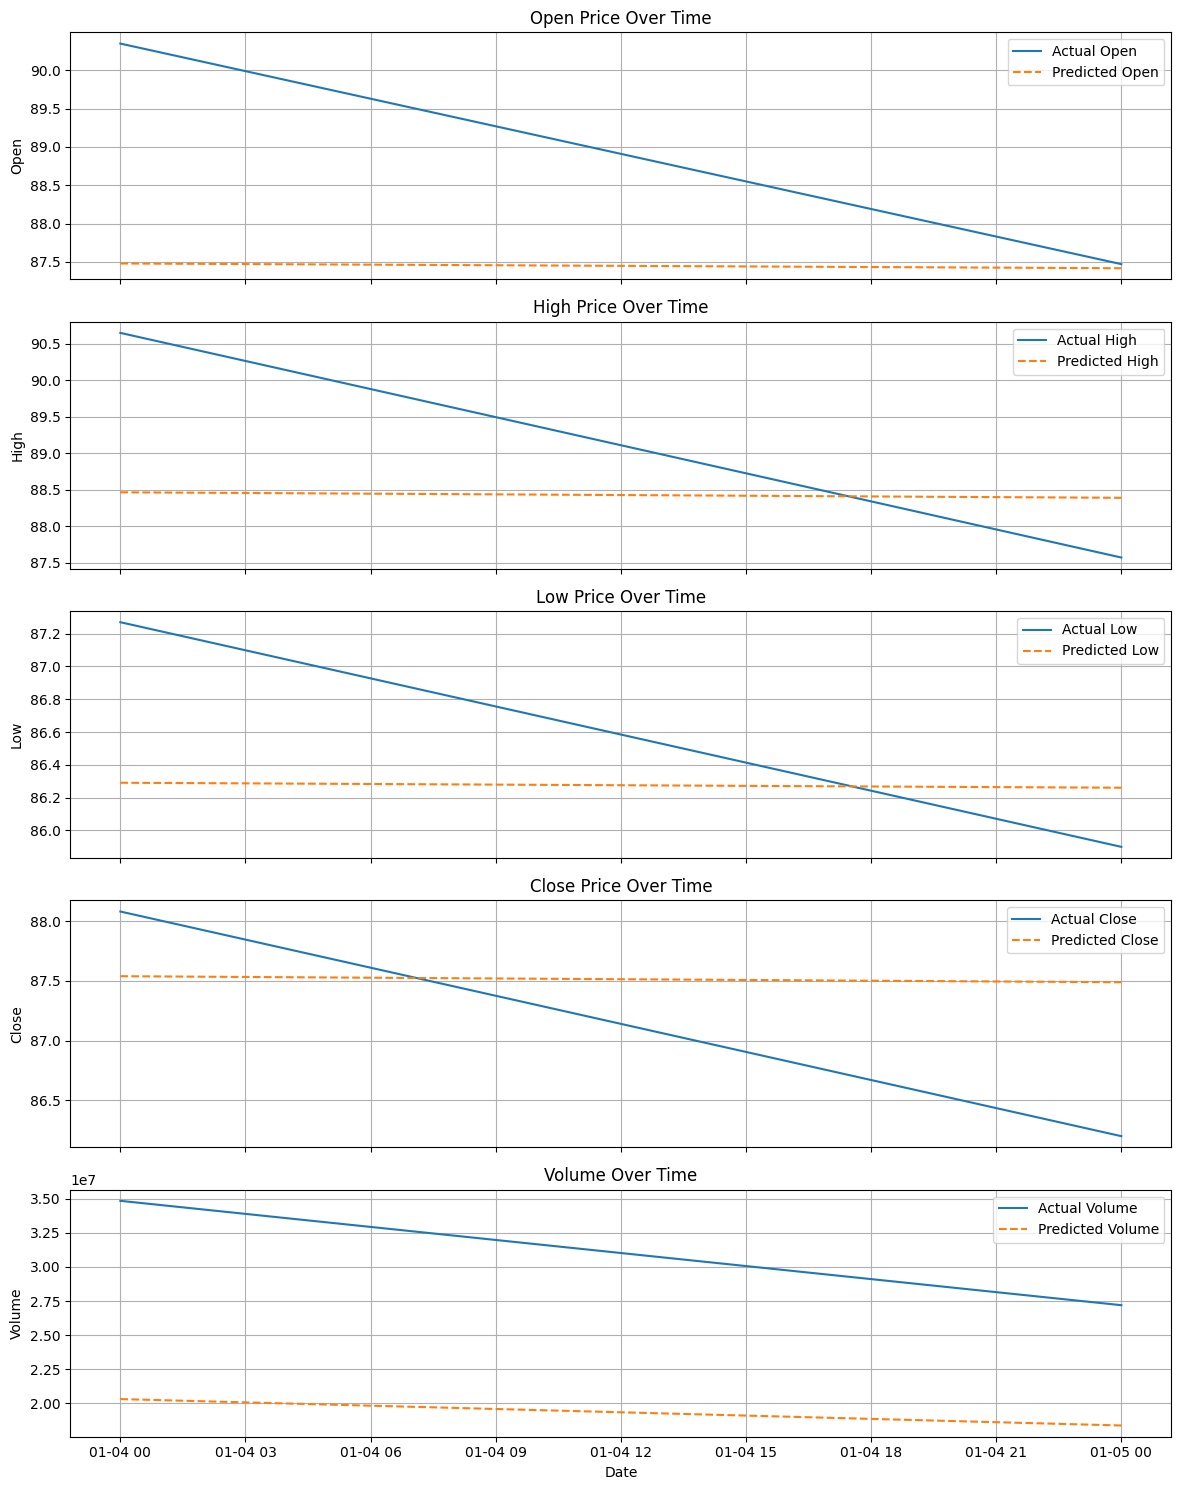

In [145]:
import predictor
importlib.reload(predictor)
from predictor import Predictor

# Initialize the Predictor
predictor = Predictor(
    model=model,
    scaler=pp.scaler,
    volume_scaler=pp.volume_scaler,
    sequence_length=sequence_length,
    device=device
)

# Specify parameters for prediction
start_date = date(2023, 1, 3)

days_to_predict = 2

# Perform the prediction
dataset = pp.load_data()  # Load the dataset to access dates
dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
predicted_values, predicted_values_scaled = predictor.predict_future(dataset, start_date, days_to_predict)

# Extract actual values for comparison
start_index = dataset.index[dataset['Date'] == start_date][0]
actual_values = dataset.iloc[start_index + 1:start_index + 1 + days_to_predict][['Open', 'High', 'Low', 'Close', 'Volume']].values
actual_values_scaled = predictor.scale(actual_values).cpu().numpy()

# Evaluate predictions using multiple metrics
mse = np.mean((actual_values_scaled - predicted_values_scaled) ** 2)  # Mean Squared Error
mae = np.mean(np.abs(actual_values_scaled - predicted_values_scaled))  # Mean Absolute Error
variance = np.var(actual_values_scaled - predicted_values_scaled)  # Variance of errors


# Compare predicted values with actual values
print(f"\nPredictions vs Actuals starting from {start_date.strftime('%Y-%m-%d')} for {days_to_predict} days:")

for i, (prediction, actual) in enumerate(zip(predicted_values, actual_values)):
    prediction_date = dataset.iloc[start_index + 1 + i]['Date']
    print(f"Date: {prediction_date}")
    print(f"Predicted: {prediction}")
    print(f"Actual: {actual}")
    print("---")
    
# Print evaluation metrics
print(f"Test Metrics:")
print(f"MSE: {mse:.6f}")  # Mean Squared Error -> Smaller values indicate better model performance.
print(f"MAE: {mae:.6f}")  # Mean Absolute Error -> Provides a more interpretable metric compared to MSE (does not square the errors).
print(f"Variance of errors: {variance:.6f}")  # Variance -> Lower variance indicates that the model consistently makes predictions close to the actual values.

# Plot
plotter = DataPlotter()
# Create a DataFrame for results
df_results = plotter.create_results_dataframe(
    dates=dataset["Date"].iloc[start_index + 1:start_index + 1 + days_to_predict],  # Use the dates for the prediction range
    actuals_original=actual_values,
    predictions_original=predicted_values
)
# Plot results for the prediction range
plotter.plot_results(df_results
)

In [150]:
# Example: Simulate profit based on predictions
initial_capital = 1000  # Starting capital in dollars
capital = initial_capital
stock_held = 0

for i in range(len(predicted_values) - 1):
    predicted_close_today = predicted_values[i][3]  # Predicted Close
    predicted_open_tomorrow = predicted_values[i + 1][0]  # Predicted Open

    # Simple strategy: Buy if tomorrow's Open is higher than today's Close
    if predicted_open_tomorrow > predicted_close_today:
        stock_held = capital / predicted_close_today
        capital = 0
    # Sell if tomorrow's Open is lower than today's Close
    elif stock_held > 0:
        capital = stock_held * predicted_open_tomorrow
        stock_held = 0

# Final capital value
final_capital = capital + (stock_held * predicted_values[-1][3] if stock_held > 0 else 0)
profit = final_capital - initial_capital

print(f"Final Capital: ${final_capital:.2f}")
print(f"Profit: ${profit:.2f}")

Final Capital: $1000.00
Profit: $0.00


Simulating the "Without Predictions" Strategy

In [147]:
# Simulation parameters
initial_capital = 1000  # Starting capital in dollars
profit_threshold = 0.10  # 10% profit
loss_threshold = -0.05  # 5% loss
moving_avg_days = 5  # "Looks good" condition based on moving average

# Variables to track
capital = initial_capital
stock_held = 0
buy_price = None

# Run the simulation
for i in range(moving_avg_days, len(actual_values)):
    # Calculate moving average for the "looks good" condition
    moving_avg = actual_values[i - moving_avg_days:i, 3].mean()  # Use 'Close' price for the average
    today_price = actual_values[i, 3]  # Today's closing price

    # If no stock held, decide to buy
    if stock_held == 0 and today_price < moving_avg:  # Looks good condition
        stock_held = capital / today_price
        capital = 0
        buy_price = today_price
        print(f"Buy: {today_price:.2f} on day {i}")

    # If stock is held, decide to sell based on profit/loss thresholds
    elif stock_held > 0:
        current_value = stock_held * today_price
        profit_loss = (today_price - buy_price) / buy_price

        if profit_loss > profit_threshold or profit_loss < loss_threshold:
            capital = current_value
            stock_held = 0
            print(f"Sell: {today_price:.2f} on day {i} (Profit/Loss: {profit_loss:.2%})")

# Final capital
final_capital_no_predictions = capital + (stock_held * actual_values[-1, 3] if stock_held > 0 else 0)
profit_no_predictions = final_capital_no_predictions - initial_capital

print(f"Final Capital Without Predictions: ${final_capital_no_predictions:.2f}")
print(f"Profit Without Predictions: ${profit_no_predictions:.2f}")

Final Capital Without Predictions: $1000.00
Profit Without Predictions: $0.00


Simulating the "With Predictions" Strategy

In [148]:
# Simulation parameters
initial_capital = 1000  # Starting capital in dollars
profit_threshold = 0.10  # 10% profit
loss_threshold = -0.05  # 5% loss

# Variables to track
capital = initial_capital
stock_held = 0
buy_price = None

# Run the simulation
for i in range(len(predicted_values) - 1):
    today_price = actual_values[i, 3]  # Today's closing price
    tomorrow_predicted_price = predicted_values[i + 1, 3]  # Predicted Close price tomorrow

    # If no stock held, decide to buy
    if stock_held == 0 and tomorrow_predicted_price > today_price:  # Buy if predicted price increases
        stock_held = capital / today_price
        capital = 0
        buy_price = today_price
        print(f"Buy: {today_price:.2f} on day {i}")

    # If stock is held, decide to sell based on profit/loss thresholds
    elif stock_held > 0:
        current_value = stock_held * today_price
        profit_loss = (today_price - buy_price) / buy_price

        if profit_loss > profit_threshold or profit_loss < loss_threshold:
            capital = current_value
            stock_held = 0
            print(f"Sell: {today_price:.2f} on day {i} (Profit/Loss: {profit_loss:.2%})")

# Final capital
final_capital_with_predictions = capital + (stock_held * actual_values[-1, 3] if stock_held > 0 else 0)
profit_with_predictions = final_capital_with_predictions - initial_capital

print(f"Final Capital With Predictions: ${final_capital_with_predictions:.2f}")
print(f"Profit With Predictions: ${profit_with_predictions:.2f}")

Final Capital With Predictions: $1000.00
Profit With Predictions: $0.00


Comparing Results

In [149]:
print(f"\nComparison of Strategies:")
print(f"Profit Without Predictions: ${profit_no_predictions:.2f}")
print(f"Profit With Predictions: ${profit_with_predictions:.2f}")
if profit_with_predictions > profit_no_predictions:
    print("Using the model predictions resulted in better profits.")
else:
    print("The basic strategy without predictions performed better.")


Comparison of Strategies:
Profit Without Predictions: $0.00
Profit With Predictions: $0.00
The basic strategy without predictions performed better.
